---
Visualization of Concept disentanglement
---


**Description:**  
The channels and relevance of the concept dientanglement process are stored, we visualize the sub channels and relevance flow
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [1]:
import os
import io
import sys

from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from crp.image import imgify,vis_opaque_img

In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))
from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel
from sentinelmodels.preprocessing import SentinelDataset
from interpet.concept.conceptrelevance import ConceptRelevance

In [3]:

config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "symmetric":False,
                "level":1
                }

modelindex=-1
datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/wilderness_data.pkl"

loaded_data = dictionary = load_dict(datafilepath)
# Accessing the loaded images and labels
images = loaded_data["images"][-1,:,:,:].unsqueeze(dim=0).to(config["device"])
#images = loaded_data["images"].to(config["device"])

labels = loaded_data["labels"]

In [4]:
modelindex=-1
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])
Concepts=ConceptRelevance(model,device=config["device"])
del model

In [5]:
recordlayers=list(Concepts.layer_map.keys())
print(recordlayers)

['features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'common_layers.0', 'common_layers.3', 'common_layers.6']


In [6]:
layername=recordlayers[-5] #selecting layer
initial_channel=21 # selecting channel
width=[3,2,1]

In [7]:
subconcepts=load_dict(r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/relevance_dict/disentangled_concepts/resnet18_features.7.1.conv1conceptdisentanglement_relevance.pkl")

In [8]:
subconcepts

({'features.7.1.conv1': [485],
  'features.7.0.conv2': [505, 185, 460],
  'features.7.0.conv1': [309, 307, 51, 184, 124, 251]},
 {('features.7.0.conv2',
   'features.7.1.conv1:features.7.0.conv2'): [(505,
    '485:505',
    0.029183553531765938), (185, '485:185', 0.025694387033581734), (460,
    '485:460',
    0.022015469148755074)],
  ('features.7.0.conv1',
   'features.7.0.conv2:features.7.0.conv1'): [(309,
    '505:309',
    0.03314535692334175), (307, '505:307', 0.032596979290246964), (51,
    '185:51',
    0.03829281032085419), (184, '185:184', 0.03805585578083992), (124,
    '460:124',
    0.034524306654930115), (251, '460:251', 0.0330413356423378)],
  'features.7.1.conv1': [485]})

In [9]:
def remove_duplicates(lst):
    seen = set()
    unique_list = []
    for item in lst:
        if item not in seen:
            unique_list.append(item)
            seen.add(item)
    return unique_list


def generate_condition_list(subconceptdict,prediction=[1]):
    conditionlist=[]
    basedict={"y":prediction}
    layernameslist=list(subconceptdict.keys())
    firstlayername=layernameslist[-1]
    for key,value in subconceptdict.items():
        subconceptdict[key]=remove_duplicates(value)
    for channelindex in subconceptdict[firstlayername]:
        basedict[firstlayername]=[channelindex]
        conditionlist.append(basedict)

    for layername in layernameslist[:-1]:
        inputlayername,outputlayername=layername[1].split(":")
        for channelindex in subconceptdict[layername]:
            inputchannel,outputchannel=channelindex[1].split(":")
            for condition in conditionlist:
                if inputlayername in condition:
                    if condition[inputlayername]==[int(inputchannel)]:
                        if outputlayername not in condition:
                            condition[outputlayername]=[int(outputchannel)]
                        elif not condition[outputlayername]==[int(outputchannel)]:
                            newcondition=dict(condition)
                            newcondition[outputlayername]=[int(outputchannel)]
                            conditionlist.append(newcondition)
                            break
    return conditionlist

def create_progressive_dicts(original_dict,start_index=3):
    keys = list(original_dict.keys())
    progressive_dicts = []

    for i in range(start_index, len(keys) + 1):
        # Slice the keys list up to the current index and form a new dictionary
        new_dict = {key: original_dict[key] for key in keys[:i]}
        progressive_dicts.append(new_dict)

    return progressive_dicts

In [10]:
conditions=generate_condition_list(subconcepts[1],prediction=[1])

In [11]:
for conditon in conditions[:1]:
    print(conditon)
    lsitofdict=create_progressive_dicts(conditon,start_index=2)
    print(lsitofdict)

{'y': [1], 'features.7.1.conv1': [485], 'features.7.0.conv2': [505], 'features.7.0.conv1': [309]}
[{'y': [1], 'features.7.1.conv1': [485]}, {'y': [1], 'features.7.1.conv1': [485], 'features.7.0.conv2': [505]}, {'y': [1], 'features.7.1.conv1': [485], 'features.7.0.conv2': [505], 'features.7.0.conv1': [309]}]


In [12]:
conceptimages={}
start_index=2
index=0
for conditon in conditions:
    lsitofdict=create_progressive_dicts(conditon,start_index=start_index)
    index+=1
    for subcondition in lsitofdict:
        items = list(subcondition.items())
        subcondition = dict(items)
        ccondheatmap,_,_=Concepts.conditional_relevance(images,condition=[subcondition],compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="softmax",record_layer=recordlayers[:1])
        flattened_values = [str(item) for sublist in subcondition.values() for item in sublist]
        result_str = '_'.join(flattened_values)
        conceptimages[result_str]=(imgify(ccondheatmap,cmap="hot",symmetric=False,level=1.0),vis_opaque_img(images,abs(ccondheatmap),alpha=0.1,kernel_size=5)[0],ccondheatmap.sum()*100)

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\zennit\image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


In [13]:
# Assuming you have 16 images, replace these paths with your actual image paths
image_paths = sorted(list(conceptimages.keys()),key=len)  # Replace with your image paths
image_paths = sorted(list(conceptimages.keys()), key=lambda s: (len(s), s))

In [14]:
dictrel={}
for layername,value in subconcepts[1].items():
    dictrel[layername[0]]=[]
    
    for index in value:
        appendvalue=False
        if isinstance(index,tuple):
            if len(dictrel[layername[0]])==0:
                dictrel[layername[0]].append([index[0],index[-1]*100])
            else:
                for chindex in dictrel[layername[0]]:
                    if chindex[0]==index[0]:
                        chindex[1]+=index[-1]*100
                        break
                    else:
                        appendvalue=True
        if appendvalue:
            dictrel[layername[0]].append([index[0],index[-1]*100])
print(dictrel)    

{'features.7.0.conv2': [[505, 2.918355353176594], [185, 2.5694387033581734], [460, 2.2015469148755074]], 'features.7.0.conv1': [[309, 3.314535692334175], [307, 3.2596979290246964], [51, 3.8292810320854187], [184, 3.805585578083992], [124, 3.4524306654930115], [251, 3.30413356423378]], 'f': []}


In [15]:
columnlabels=list(subconcepts[0].keys())

In [16]:
image_paths

['1_485',
 '1_485_185',
 '1_485_460',
 '1_485_505',
 '1_485_185_51',
 '1_485_185_184',
 '1_485_460_124',
 '1_485_460_251',
 '1_485_505_307',
 '1_485_505_309']

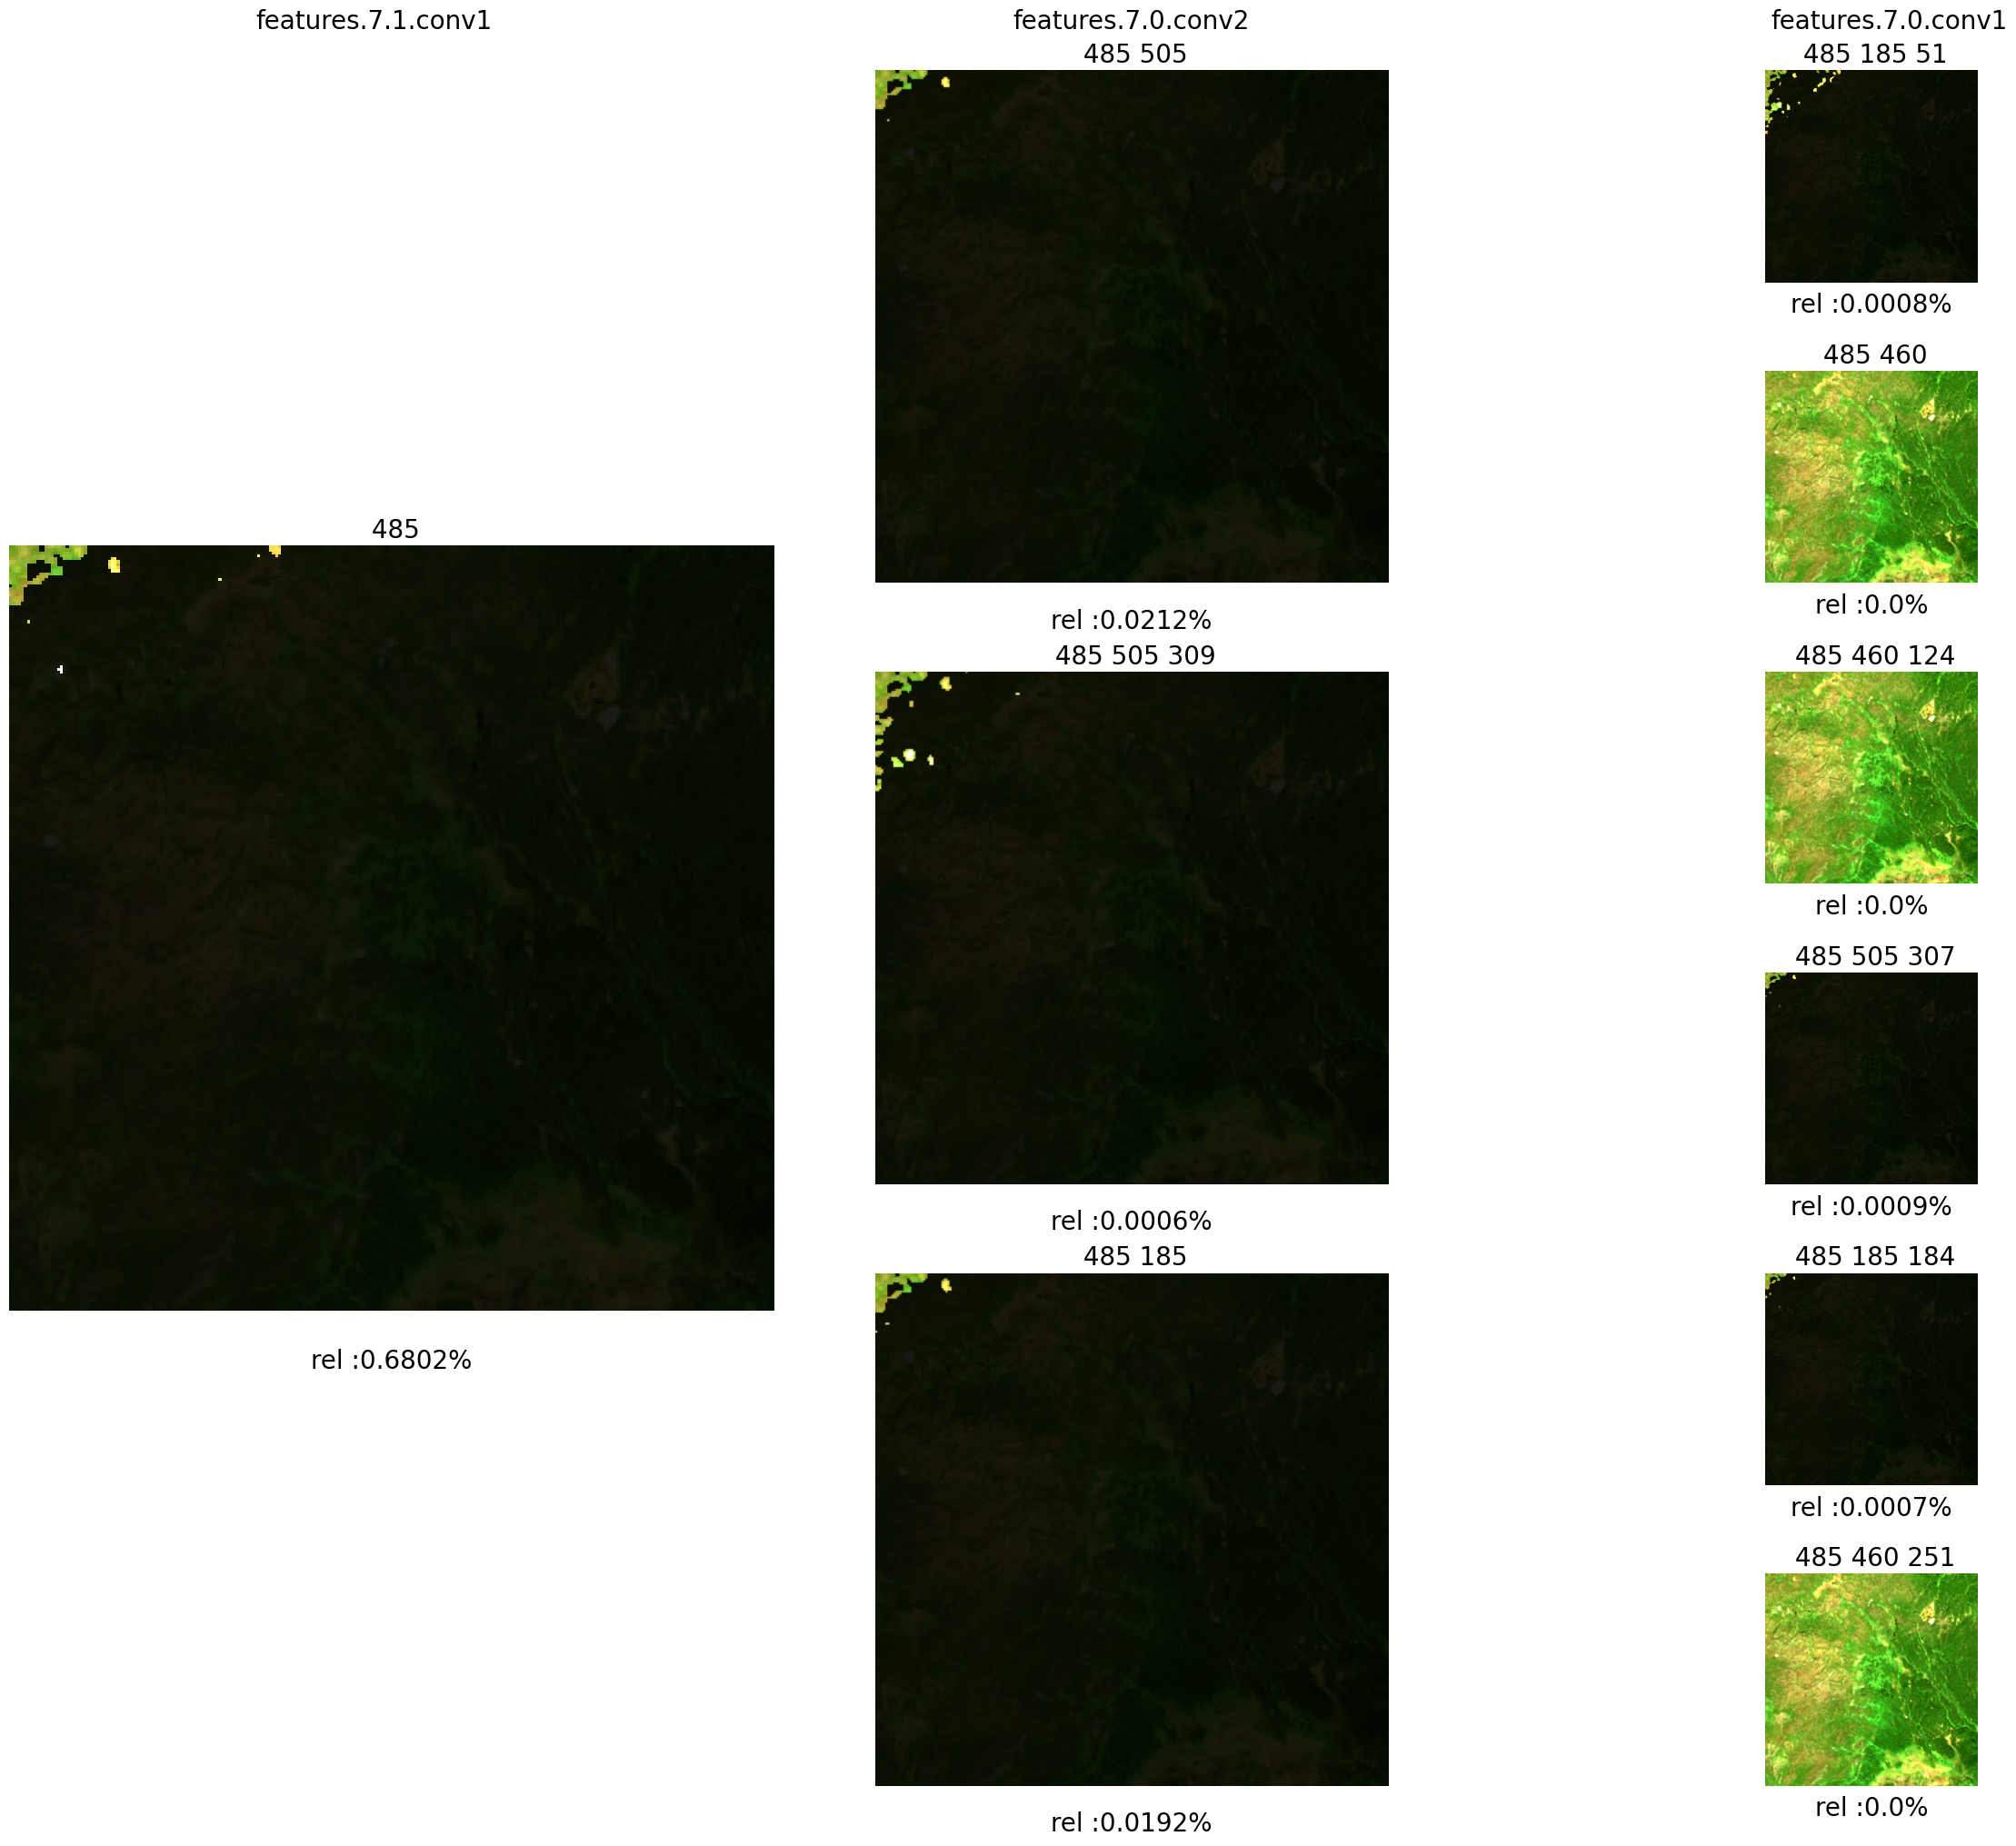

In [19]:
# Image distribution in each column
image_distribution = [1, 3, 6]
columnlabels = list(subconcepts[0].keys())

# Calculate total rows and columns for the grid
total_rows = max(image_distribution)  # No extra row needed
total_columns = len(image_distribution)

# Create a figure with a specified size
fig = plt.figure(figsize=(25, 20))  # Adjust figure size as needed
gs = gridspec.GridSpec(total_rows, total_columns, figure=fig)

# Rest of your functions remain the same
def calculate_spans(total_cols, num_images):
    spans = []
    step = total_cols // num_images
    for i in range(num_images):
        start_col = i * step
        end_col = start_col + step
        spans.append((start_col, end_col))
    return spans

# Function to add image and text to the subplot
def add_image_with_text(ax, img_path, title="", img_index=1,fontsize=20):
    ax.imshow(conceptimages[img_path][img_index])
    ax.set_title(img_path[1:].replace("_", " "), fontsize=fontsize)
    ax.axis('off')
    ax.text(0.5, -0.05, "rel :"+str(round(conceptimages[img_path][-1].item(),4))+"%", ha='center', va='top', transform=ax.transAxes, fontsize=fontsize)  # Adjust text positioning and size here

# Function to add column titles
def add_column_titles(fig, labels, fontsize=20):
    for i, label in enumerate(labels):
        # Calculate the center position of each column
        x_position = (2 * i + 1) / (2 * total_columns)
        fig.text(x_position, 1, label, ha='center', fontsize=fontsize, transform=fig.transFigure)

# Add titles to each column
add_column_titles(fig, columnlabels)

# Iterate over columns and add images
image_index = 0
for col, num_images in enumerate(image_distribution):
    spans = calculate_spans(total_rows, num_images)
    for span in spans:
        ax = fig.add_subplot(gs[span[0]:span[1], col])
        img_key = list(conceptimages.keys())[image_index]
        add_image_with_text(ax, img_key)
        image_index += 1
# Display the plot
plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_"+layername+"_"+str(subconcepts[0][layername][0])+"_concepts_disentanglement.png"),dpi=600)
plt.show()
